In [1]:
%pylab inline
import tensorflow as tf
import re

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


Populating the interactive namespace from numpy and matplotlib


In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

In [4]:
CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'})
)


cifar10_train = CIFAR10(("train",), subset=slice(None, 40000))
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 25)
)

cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, 
    iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 100)
)

cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test,
    iteration_scheme=SequentialScheme(cifar10_test.num_examples, 100)
)

In [5]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [6]:
def conv2d_layer(X, filter_shape, num_filters, padding='VALID', activation=None, name=None):
    name = name or "conv2d_layer"
    num_channels = X.shape[3].value
    with tf.variable_scope(None, default_name=name):
        F = tf.get_variable('F',
            (filter_shape[0], filter_shape[1], num_channels, num_filters), 
            'float32', 
            initializer=tf.contrib.layers.xavier_initializer_conv2d()
        )
        b = tf.get_variable('b',
            (1, 1, 1, num_filters),
            'float32',
            initializer=tf.zeros_initializer()
        )
        Y = tf.nn.conv2d(X, F, (1, 1, 1, 1), padding=padding) + b
        return activation(Y) if activation else Y

In [7]:
def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W',
            (X.shape[1].value, num_hidden),
            'float32',
            initializer=tf.contrib.layers.xavier_initializer()
        )
        b = tf.get_variable('b',
            (1, num_hidden),
            'float32',
            initializer=tf.zeros_initializer()
        )
        Y = tf.matmul(X, W) + b
        return activation(Y) if activation else Y

In [8]:
def max_pool_2x2(X, padding='VALID'):
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=padding)

In [9]:
X = tf.placeholder(shape=(None, 3, 32, 32), dtype=np.float32, name='X')
X_NHWC = tf.transpose(X, [0, 2, 3, 1])
Y = tf.placeholder(shape=(None, 1), dtype=np.int32, name='Y')

X_flat = tf.reshape(X, (-1, np.prod(X.shape.as_list()[1:])))

In [100]:
# Network hyperparams

conv_layers = [((5, 5), 64), ((5, 5), 128), ((5, 5), 256)]
affine_layers = [1024, 512]

dropout_prob = 0.8  # unused
wd_factor = 1.0e-5  # unused
learning_rate_v = 1.0e-4  # unused

In [101]:
# Building the network

L = X_NHWC
print ("Input shape %s" % (L.shape,))

for filter_size, num_filters in conv_layers:
    L = conv2d_layer(L, filter_size, num_filters, activation=tf.nn.relu, padding="SAME")
    print ("After conv shape %s" % (L.shape,))
    L = max_pool_2x2(L)
    print ("After pool shape %s" % (L.shape,))
    L = tf.nn.dropout(L, keep_prob=0.75)

L = tf.reshape(L, (-1, np.prod(L.shape.as_list()[1:])))
print ("After flattening %s" % (L.shape,))

for num_hidden in affine_layers:
    L = affine_layer(L, num_hidden, activation=tf.nn.relu)
    print ("After affine %s" % (L.shape,))
    
L = affine_layer(L, 10)
print ("After affine %s" % (L.shape,))

Input shape (?, 32, 32, 3)
After conv shape (?, 32, 32, 64)
After pool shape (?, 16, 16, 64)
After conv shape (?, 16, 16, 128)
After pool shape (?, 8, 8, 128)
After conv shape (?, 8, 8, 256)
After pool shape (?, 4, 4, 256)
After flattening (?, 4096)
After affine (?, 1024)
After affine (?, 512)
After affine (?, 10)


In [102]:
# Loss function

per_example_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=L, labels=tf.reshape(Y, (-1,)))
xentropy_loss = tf.reduce_mean(per_example_loss)

weight_decay_loss = 0.0
for V in tf.trainable_variables():
    if re.match(V.name, ".*/W.*"):
        weight_decay_loss += 1.0e-5 * tf.reduce_sum(V**2)

batch_loss = xentropy_loss + weight_decay_loss
classification = tf.argmax(L, axis=1)

In [103]:
learning_rate = tf.get_variable('learning_rate', shape=(), dtype='float32', trainable=False)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(batch_loss)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))
initialize_op = tf.global_variables_initializer()

In [104]:
# Session

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(initialize_op)

train_loss_history = []
valid_loss_history = []
epoch = 0

In [105]:
sess.run(learning_rate.assign(1e-4))

9.9999997e-05

In [106]:
def calculate_success_rate(stream):
    stats = []
    for batch_X, batch_Y in stream.get_epoch_iterator():
        feed_dict = {X: batch_X, Y: batch_Y}
        res, loss = sess.run([classification, batch_loss], feed_dict=feed_dict)
        accuracy = np.mean(res == batch_Y[:, 0])
        stats.append((accuracy, loss))
    return np.mean(stats, axis=0)

In [113]:
# Training

global_step_v = sess.run(global_step)

while global_step_v < 30000:
    epoch += 1

    for batch_X, batch_Y in cifar10_train_stream.get_epoch_iterator():
        feed_dict = {X: batch_X, Y: batch_Y}
        _, global_step_v, loss_v = sess.run([train_op, global_step, batch_loss], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            train_loss_history.append((epoch, global_step_v, loss_v,))
            print ("epoch: %d, step: %d, loss: %g" % (epoch, global_step_v, loss_v,))
    
    valid_acc, valid_loss = calculate_success_rate(cifar10_validation_stream)
    print ("epoch: %d, step: %d, valid_loss: %g, valid_acc: %f" % (epoch, global_step_v, valid_loss, valid_acc))
    valid_loss_history.append((epoch, global_step_v, valid_loss, valid_acc))

epoch: 17, step: 26001, loss: 0.0650499
epoch: 17, step: 27001, loss: 0.212272
epoch: 17, step: 27200, valid_loss: 1.00866, valid_acc: 0.760700
epoch: 18, step: 28001, loss: 0.181686
epoch: 18, step: 28800, valid_loss: 1.02131, valid_acc: 0.759300
epoch: 19, step: 29001, loss: 0.0430349
epoch: 19, step: 30001, loss: 0.0429176
epoch: 19, step: 30400, valid_loss: 1.09077, valid_acc: 0.759700


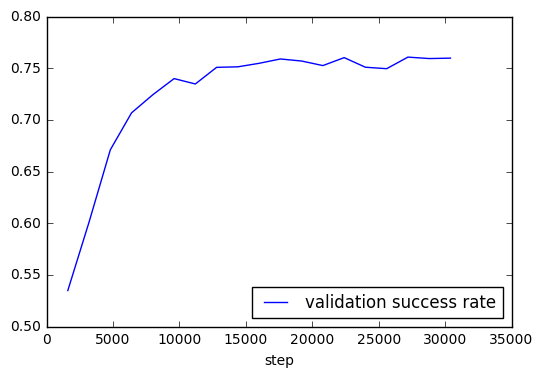

In [114]:
valid_stats = np.array(valid_loss_history, dtype=np.float32)
plot(valid_stats[:, 1], valid_stats[:, 3], label='validation success rate')
xlabel('step')
legend(loc=4)

In [115]:
print "Average test accuracy:", calculate_success_rate(cifar10_test_stream)[0]

Average test accuracy: 0.7565
